In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pathlib
import time
import datetime
import os
import numpy as np
import random
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1177989684
import tensorflow as tf
from IPython import display

# Preparation of the dataset
From the DSM and DTM, 256x256 patches are selected if they are completely included in Brussels (no pixel out of the border, which have a value of -3.4028235e+38)<br>
The DSM and corresponding DTM patches are stuck in a single 256x512 image and saved as jpeg.<br>
80% of the images are selected for training, 10% for testing and 10% for validation

In [5]:
dsm = np.array(Image.open('Urbis/UrbDSMY21_RBC_50cm/UrbDSMY21_RBC_50cm.tif'))
dtm = np.array(Image.open('Urbis/UrbDTMY21_RBC_50cm/UrbDTMY21_RBC_50cm.tif'))

In [ ]:
n=0
val = dsm[0][0]
y = 0

windows = []

for i in range(0, dsm.shape[0]-256,256):
    #print(i)
    for j in range(dsm.shape[1]):
        if y >= dsm.shape[1] - 256:
            y = 0
            break
        if not val in dsm[i:i+256,y:y+256]:
            windows.append((i,y))
            y += 256
            n+=1
        else : 
            y += 1
            
print(n)  
            
                

In [ ]:
def list_dif(list1, list2):
    res = list1
    for item in list2:
        res.remove(item)
    return res

items = list(range(10496))
train = random.sample(items, 8397)
items = list_dif(items, train)
test = random.sample(items, 1050)
val = list_dif(items, test)

def save_images(images_list, sample, name):
    id = 1
    for item in sample:
        w = images_list[item]
        im = Image.fromarray(np.concatenate((dsm[w[0]:w[0]+256,w[1]:w[1]+256], dtm[w[0]:w[0]+256,w[1]:w[1]+256]), axis=1)).convert('F')
        im.save('dataset/' + name + '/'+ str(id)+'.tif')
        id+=1
    return 0



In [ ]:
save_images(windows, train, 'train')
save_images(windows, test, 'test')
save_images(windows, val, 'val')

In [ ]:
def save_np(windows,sample, name):
    i = 1
    for item in sample:
        w = windows[item]
        image = np.concatenate((dsm[w[0]:w[0]+256,w[1]:w[1]+256], dtm[w[0]:w[0]+256,w[1]:w[1]+256]), axis=1)
        image.tofile('np_dataset/' + name+ '/' + str(i))
        i += 1
    return 0

In [ ]:
save_np(windows, train, 'train')
save_np(windows, test, 'test')
save_np(windows, val, 'val')

In [ ]:
test = np.fromfile('np_dataset/train/1')
test.shape
#plt.imshow(test)

# Pix2pix tensorflow tutorial

## Load dataset

In [9]:
tif_image = Image.fromarray(np.array(dsm)[10000:10256,10000:10512])
tif_image.save('tif_image.tif')

In [3]:
def load(image_file):
    image = np.array(Image.open(image_file))
    shape = image.shape
    if len(shape) == 2:
        image = image.reshape((shape[0], shape[1],1))
    w = shape[1]//2
    input_image = image[:, :w,:]
    real_image = image[:, w:,:]
    #input_image = tf.cast(input_image, tf.float32)
    #real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image    

<class 'numpy.ndarray'>


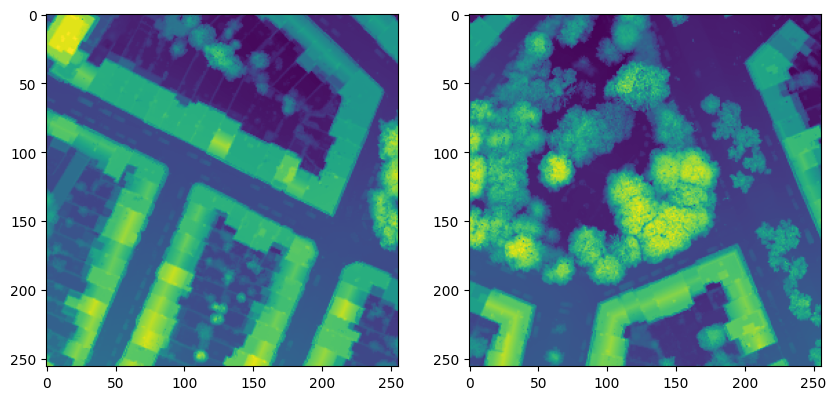

In [12]:
inp, re = load('tif_image.tif')
# Casting to int for matplotlib to display the images
print(type(inp))
fig=plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(inp / 255.0)
plt.subplot(1,2,2)
plt.imshow(re / 255.0)


In [11]:
inp

array([[[55.205658],
        [55.510593],
        [56.050327],
        ...,
        [51.817596],
        [51.118996],
        [51.20856 ]],

       [[55.505226],
        [56.166096],
        [56.065132],
        ...,
        [50.82783 ],
        [50.872955],
        [51.78333 ]],

       [[55.806618],
        [55.471687],
        [55.49321 ],
        ...,
        [51.494328],
        [51.729824],
        [51.22247 ]],

       ...,

       [[68.43828 ],
        [68.5831  ],
        [66.06879 ],
        ...,
        [56.995857],
        [54.91097 ],
        [54.062332]],

       [[68.6307  ],
        [68.56436 ],
        [68.57305 ],
        ...,
        [57.75577 ],
        [55.13061 ],
        [54.206142]],

       [[68.5809  ],
        [68.57914 ],
        [68.571686],
        ...,
        [58.28074 ],
        [57.011158],
        [55.524796]]], dtype=float32)

In [ ]:
# The facade training set consist of 8398 images
BUFFER_SIZE = 8398
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256


In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])

  return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()


In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
type(load_image_train('dataset/test/1.tif')[0])

## Build input pipeline

In [ ]:
TEST = True

In [ ]:
def np_dataset(set_type):
    path = 'dataset/' + set_type
    names = os.listdir(path)
    dataset = []
    load_fct = eval('load_image_' + set_type)
    for name in names:
        if name != '.ipynb_checkpoints':
            inp, re = load_fct(path + '/' + name)
            dataset.append([inp, re])
    return np.array(dataset)

def div(x):
    return x[0], x[1]

In [ ]:
train_dataset = np_dataset('train')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.map(div, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
train_dataset.take(1)

In [ ]:
if TEST:
    test_dataset = np_dataset('test')
else:
    test_dataset = np_dataset('val')
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.map(div, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [ ]:
test_dataset.take(1)

## Build generator

In [ ]:
inp

In [ ]:
OUTPUT_CHANNELS = 1


def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


down_model = downsample(1, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)


In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(1, 4)
up_result = up_model(down_result)

print (up_result.shape)


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
generator = Generator()
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## Generator loss

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Discriminator

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [ ]:
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


### Discriminator loss

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Optimizers and checkpoints

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


### Generate images

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


In [ ]:
for example_input, example_target in test_dataset.take(3):
  generate_images(generator, example_input, example_target)


## Training

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)


In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
fit(train_dataset, test_dataset, steps=8398)

In [ ]:
generate_images(generator, example_input, example_target)

In [ ]:
ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))